# Introduction
The adoption of computer vision in agriculture has seen remarkable growth in recent years, offering innovative solutions to enhance farming efficiency. One of the most impactful applications of this technology is the classification of fruits and vegetables based on their health status. This project is focused on designing a robust image classification model leveraging Keras, KerasCV, and TensorFlow to distinguish between healthy and rotten produce.

Accurate classification of fruits and vegetables plays a pivotal role for stakeholders across the agricultural supply chain, including farmers, retailers, and consumers. For farmers, early identification of spoiled produce minimizes wastage and improves harvest planning. Retailers can streamline inventory management and ensure only premium-quality products are available for purchase. For consumers, this provides confidence in the freshness and safety of the food they buy.

# Problem Statement
The primary goal of this project is to build an efficient and precise image classification model capable of differentiating between rotten and healthy fruits and vegetables. An automated system for detecting and classifying produce quality is essential for several reasons:

**Quality Assurance**

1. Ensures that only high-quality and safe products reach the market, maintaining consumer satisfaction and trust.
Waste Reduction and Efficiency

2. Identifies rotten produce early in the supply chain, leading to lower waste and cost savings through better resource allocation.
Food Safety Standards

3. Prevents the distribution of contaminated or spoiled produce, protecting public health and meeting safety regulations.

In [ ]:
!nvidia-smi

Wed Jan  8 12:20:15 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import files
files.upload()


{}

In [ ]:
# Create a directory for Kaggle API token
!mkdir -p ~/.kaggle

# Move the uploaded token to this directory
!cp kaggle.json ~/.kaggle/

# Set permissions for the file
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!pip install kaggle


In [ ]:
!kaggle datasets download -d muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten



Dataset URL: https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten
License(s): CC0-1.0
100% 4.76G/4.77G [04:08<00:00, 19.9MB/s]
100% 4.77G/4.77G [04:08<00:00, 20.6MB/s]


In [ ]:
!unzip fruit-and-vegetable-disease-healthy-vs-rotten.zip -d dataset


Streaming output truncated to the last 5000 lines.
  inflating: dataset/Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (85).jpg  
  inflating: dataset/Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (86).jpg  
  inflating: dataset/Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (87).jpg  
  inflating: dataset/Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (88).jpg  
  inflating: dataset/Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (89).jpg  
  inflating: dataset/Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (9).jpg  
  inflating: dataset/Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (90).jpg  
  inflating: dataset/Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (91).jpg  
  inflating: dataset/Fruit And Vegetable Diseases Dataset/Potato__Healthy/freshPotato (92).jpg  
  inflating: dataset/Fruit And Vegetable Diseases Dataset/Potato__Healthy/fre

In [ ]:
import os
import shutil
import keras
import random
import keras
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import image_dataset_from_directory
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
def get_sub_dirs(directory):
    sub_dirs = []
    for root, _, _, in os.walk(directory):
        if root.split('/')[-1].split('__')[-1] in ['Rotten', 'Healthy']:
            sub_dirs.append(root)
    sub_dirs.sort()
    return sub_dirs

In [ ]:
# Creating a list of all sub-directories pertaining to image categories in /kaggle/input/
sub_dirs = get_sub_dirs('/content/dataset/Fruit And Vegetable Diseases Dataset')
sub_dirs[:5]

['/content/dataset/Fruit And Vegetable Diseases Dataset/Apple__Healthy',
 '/content/dataset/Fruit And Vegetable Diseases Dataset/Apple__Rotten',
 '/content/dataset/Fruit And Vegetable Diseases Dataset/Banana__Healthy',
 '/content/dataset/Fruit And Vegetable Diseases Dataset/Banana__Rotten',
 '/content/dataset/Fruit And Vegetable Diseases Dataset/Bellpepper__Healthy']

In [ ]:
# Getting the total number of images
total_images = 0
for path in sub_dirs:
    total_images += len(os.listdir(path))
total_images

29291

In [ ]:
# Defining the directory paths
train_dir = '/kaggle/working/train-images/'
test_dir = '/kaggle/working/test-images/'


In [ ]:
# Creating the sub directories
for x in sub_dirs:
    os.makedirs(train_dir + x.split('/')[-1], exist_ok=True)
    os.makedirs(test_dir + x.split('/')[-1], exist_ok=True)

In [ ]:
# Getting the list of all subdirectories in that training-images directory
train_sub_dirs = get_sub_dirs(train_dir)
train_sub_dirs[:5]

['/kaggle/working/train-images/Apple__Healthy',
 '/kaggle/working/train-images/Apple__Rotten',
 '/kaggle/working/train-images/Banana__Healthy',
 '/kaggle/working/train-images/Banana__Rotten',
 '/kaggle/working/train-images/Bellpepper__Healthy']

In [ ]:
import os
import shutil
import random
from concurrent.futures import ThreadPoolExecutor

def copy_file(src, dst):
    shutil.copy(src, dst)

def split_and_copy_files(source_dirs, train_dir, test_dir, split_ratio=0.8):
    tasks = []  # Stores tasks for multi-threading
    num_train_files = 0
    num_test_files = 0

    # Create train and test subdirectories
    for path in source_dirs:
        folder_name = os.path.basename(path)  # Extracts folder name (e.g., Apple__Healthy)

        # Create subdirectories inside train and test folders
        os.makedirs(os.path.join(train_dir, folder_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, folder_name), exist_ok=True)

        # Get all files in the source directory and shuffle them
        files = os.listdir(path)
        random.shuffle(files)

        # Split data into train and test
        split_index = int(len(files) * split_ratio)
        train_files = files[:split_index]  # 80% for training
        test_files = files[split_index:]  # 20% for testing

        # Add train files to tasks
        for file in train_files:
            src = os.path.join(path, file)
            dst = os.path.join(train_dir, folder_name, file)
            tasks.append((src, dst))
            num_train_files += 1

        # Add test files to tasks
        for file in test_files:
            src = os.path.join(path, file)
            dst = os.path.join(test_dir, folder_name, file)
            tasks.append((src, dst))
            num_test_files += 1

    # Multi-threaded copying
    with ThreadPoolExecutor() as executor:
        executor.map(lambda task: copy_file(*task), tasks)

    print(f"Total files copied: {num_train_files} to Train and {num_test_files} to Test.")

# Example usage
if __name__ == "__main__":
    split_and_copy_files(sub_dirs, train_dir, test_dir)


Total files copied: 23426 to Train and 5865 to Test.


In [ ]:
!ls /kaggle/working/train-images



Apple__Healthy	     Carrot__Healthy	Guava__Healthy	 Orange__Healthy       Strawberry__Healthy
Apple__Rotten	     Carrot__Rotten	Guava__Rotten	 Orange__Rotten        Strawberry__Rotten
Banana__Healthy      Cucumber__Healthy	Jujube__Healthy  Pomegranate__Healthy  Tomato__Healthy
Banana__Rotten	     Cucumber__Rotten	Jujube__Rotten	 Pomegranate__Rotten   Tomato__Rotten
Bellpepper__Healthy  Grape__Healthy	Mango__Healthy	 Potato__Healthy
Bellpepper__Rotten   Grape__Rotten	Mango__Rotten	 Potato__Rotten


In [ ]:
import os

train_count = sum([len(files) for r, d, files in os.walk(train_dir)])
test_count = sum([len(files) for r, d, files in os.walk(test_dir)])

print(f"Train folder has {train_count} images.")
print(f"Test folder has {test_count} images.")


Train folder has 23426 images.
Test folder has 5865 images.


In [ ]:
print(train_dir)  # Should be '/kaggle/working/train-images/'
print(test_dir)   # Should be '/kaggle/working/test-images/'


/kaggle/working/train-images/
/kaggle/working/test-images/


In [ ]:
from keras.utils import image_dataset_from_directory

# Load training dataset
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),
    batch_size=32
)

# Load testing dataset
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=32
)


Found 23413 files belonging to 28 classes.
Found 5864 files belonging to 28 classes.


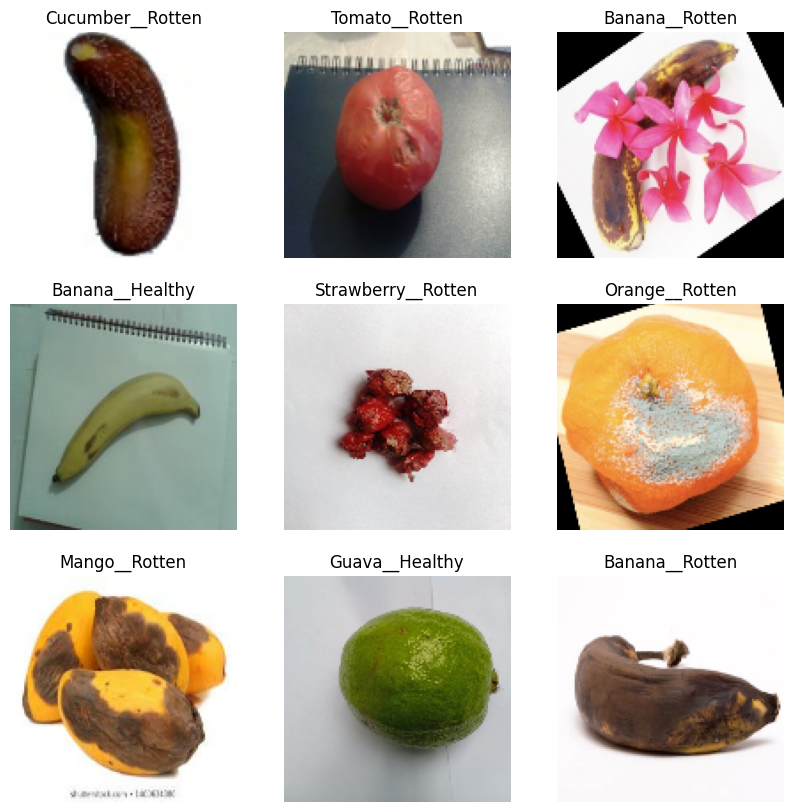

In [ ]:

# Get class names from the dataset
class_names = train_ds.class_names

# Plot images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Take one batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert to uint8
        plt.title(class_names[labels[i]])  # Get label name
        plt.axis("off")

In [ ]:
def get_img_extensions_dict(dir_paths):
    img_extension_dict = {}
    for path in dir_paths:
        for filename in os.listdir(path):
            _, file_extension = os.path.splitext(filename)
            if file_extension not in img_extension_dict:
                img_extension_dict[file_extension] = 1
            else:
                img_extension_dict[file_extension] += 1
    return img_extension_dict

In [ ]:
print(get_img_extensions_dict(train_sub_dirs))

{'.png': 9449, '.jpg': 13859, '.webp': 13, '.JPG': 40, '.jpeg': 65}


In [ ]:
from PIL import Image
import os

# Function to check color modes
def check_image_modes(directory):
    color_modes = {}  # Dictionary to store counts of each color mode
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    mode = img.mode  # Get color mode (e.g., RGB, RGBA, L)
                    if mode not in color_modes:
                        color_modes[mode] = 1
                    else:
                        color_modes[mode] += 1
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    return color_modes

# Check for train and test directories
train_modes = check_image_modes(train_dir)
test_modes = check_image_modes(test_dir)

print("Train Image Modes:", train_modes)
print("Test Image Modes:", test_modes)


Train Image Modes: {'RGB': 22483, 'P': 4, 'RGBA': 938, 'CMYK': 1}
Test Image Modes: {'RGB': 5635, 'RGBA': 229, 'P': 1}


In [ ]:
test_modes = check_image_modes(test_dir)
print("Test Modes:", test_modes)


Test Modes: {'RGB': 5635, 'RGBA': 229, 'P': 1}


In [ ]:


from PIL import Image
import os
from concurrent.futures import ProcessPoolExecutor

# Function to convert images to RGB and JPEG format
def convert_images_to_rgb_and_jpeg(directory):
    for root, dirs, files in os.walk(directory):
        for filename in files:
            # Process only supported image files
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.webp')):
                file_path = os.path.join(root, filename)
                new_file_path = os.path.join(root, os.path.splitext(filename)[0] + '.jpg')  # Save as JPEG

                try:
                    with Image.open(file_path) as img:
                        # Convert to RGB if not already RGB
                        if img.mode != 'RGB':
                            img = img.convert('RGB')  # Convert to 3 channels (RGB)

                        # Save as JPEG format
                        img.save(new_file_path, 'JPEG')

                        # Remove original file if it was not already JPEG
                        if not filename.lower().endswith('.jpg'):
                            os.remove(file_path)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

# Function to process a folder
def process_folder(folder_path):
    convert_images_to_rgb_and_jpeg(folder_path)
    print(f"Processed folder: {folder_path}")

# Paths for train and test directories
directories = [train_dir, test_dir]  # Add validation_dir if required

# Process both train and test directories using multiprocessing
with ProcessPoolExecutor() as executor:
    executor.map(process_folder, directories)

print('All images in train and test directories are converted to JPEG format and RGB color channels.')


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processed folder: /kaggle/working/test-images/
Processed folder: /kaggle/working/train-images/
All images in train and test directories are converted to JPEG format and RGB color channels.


In [ ]:
# Function to check image modes
def check_image_modes(directory):
    color_modes = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    mode = img.mode  # Check mode
                    color_modes[mode] = color_modes.get(mode, 0) + 1
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    return color_modes

# Verify train and test directories
train_modes = check_image_modes(train_dir)
test_modes = check_image_modes(test_dir)

print("Train Image Modes After Conversion:", train_modes)
print("Test Image Modes After Conversion:", test_modes)


Train Image Modes After Conversion: {'RGB': 22749}
Test Image Modes After Conversion: {'RGB': 5825}


In [ ]:
def count_images_per_class(directory):
    class_counts = {}
    for root, dirs, files in os.walk(directory):
        if root != directory:  # Skip the root directory itself
            class_name = os.path.basename(root)
            count = len([file for file in files if file.lower().endswith(('.jpg', '.png', '.jpeg'))])
            class_counts[class_name] = count
    return class_counts

# Class-wise counts
train_class_counts = count_images_per_class('/kaggle/working/train-images/')
test_class_counts = count_images_per_class('/kaggle/working/test-images/')

print("Train class-wise counts:", train_class_counts)
print("Test class-wise counts:", test_class_counts)


Train class-wise counts: {'Potato__Healthy': 488, 'Tomato__Rotten': 467, 'Jujube__Rotten': 160, 'Orange__Rotten': 1748, 'Pomegranate__Rotten': 160, 'Grape__Rotten': 160, 'Jujube__Healthy': 160, 'Banana__Healthy': 1487, 'Potato__Rotten': 466, 'Strawberry__Healthy': 1282, 'Grape__Healthy': 160, 'Tomato__Healthy': 305, 'Banana__Rotten': 2241, 'Pomegranate__Healthy': 160, 'Carrot__Rotten': 462, 'Cucumber__Rotten': 498, 'Guava__Rotten': 160, 'Apple__Healthy': 1950, 'Bellpepper__Rotten': 472, 'Orange__Healthy': 1468, 'Apple__Rotten': 2338, 'Cucumber__Healthy': 485, 'Guava__Healthy': 160, 'Mango__Rotten': 1788, 'Mango__Healthy': 1297, 'Carrot__Healthy': 484, 'Bellpepper__Healthy': 484, 'Strawberry__Rotten': 1259}
Test class-wise counts: {'Potato__Healthy': 123, 'Tomato__Rotten': 119, 'Jujube__Rotten': 40, 'Orange__Rotten': 438, 'Pomegranate__Rotten': 40, 'Grape__Rotten': 40, 'Jujube__Healthy': 40, 'Banana__Healthy': 392, 'Potato__Rotten': 117, 'Strawberry__Healthy': 321, 'Grape__Healthy': 40,

In [ ]:
# Define data augmentation transformations
datagen = ImageDataGenerator(
    rotation_range=20,            # Rotate images by up to 20 degrees
    width_shift_range=0.2,        # Shift images horizontally by 20%
    height_shift_range=0.2,       # Shift images vertically by 20%
    shear_range=0.2,              # Apply shearing transformations
    zoom_range=0.2,               # Randomly zoom images by up to 20%
    horizontal_flip=True,         # Flip images horizontally
    fill_mode='nearest'           # Fill empty pixels after transformations
)


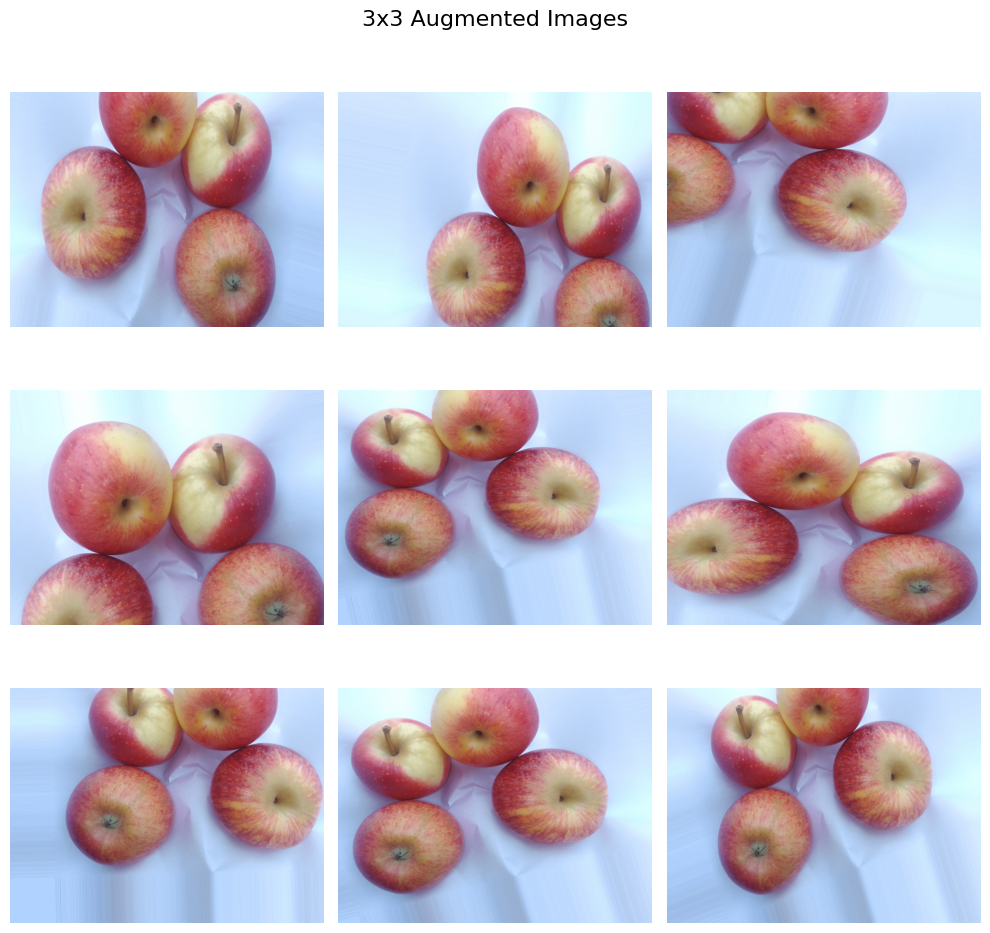

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Path to the image
img_path = '/content/dataset/Fruit And Vegetable Diseases Dataset/Apple__Healthy/FreshApple (1).jpg'  # Replace with your image path


# Load the image
img = load_img(img_path)  # Load the image
img_array = img_to_array(img)  # Convert to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Generate augmented images
aug_iter = datagen.flow(img_array, batch_size=1)

# Create a 3x3 grid to plot augmented images
plt.figure(figsize=(10, 10))  # Set the figure size
for i in range(9):  # Generate 9 images for 3x3 grid
    plt.subplot(3, 3, i + 1)  # Create 3x3 subplots
    batch = next(aug_iter)  # Generate one augmented image
    plt.imshow(batch[0].astype('uint8'))  # Display image
    plt.axis('off')  # Turn off axis
plt.suptitle("3x3 Augmented Images", fontsize=16)  # Title
plt.tight_layout()  # Adjust layout
plt.show()  # Display grid

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normalize pixel values to [0,1]
    rotation_range=20,              # Random rotation up to 20 degrees
    width_shift_range=0.2,          # Horizontal shift up to 20%
    height_shift_range=0.2,         # Vertical shift up to 20%
    shear_range=0.2,                # Shearing transformations
    zoom_range=0.2,                 # Random zoom up to 20%
    horizontal_flip=True,           # Flip images horizontally
    fill_mode='nearest'             # Fill in pixels with nearest values
)

# No Augmentation for Test Data (Only Rescaling)
test_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0,1]
)

# Train Generator
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/train-images/',  # Path to training directory
    target_size=(224, 224),           # Resize images to 224x224
    batch_size=32,                    # Batch size
    class_mode='categorical',         # Multi-class classification
    shuffle=True                      # Shuffle data for training
)

# Test Generator
test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/test-images/',   # Path to test directory
    target_size=(224, 224),           # Resize images to 224x224
    batch_size=32,                    # Batch size
    class_mode='categorical',         # Multi-class classification
    shuffle=False                     # No shuffling for test data
)

# Print Class Indices
print("Class Indices:", train_generator.class_indices)



Found 22749 images belonging to 28 classes.
Found 5825 images belonging to 28 classes.
Class Indices: {'Apple__Healthy': 0, 'Apple__Rotten': 1, 'Banana__Healthy': 2, 'Banana__Rotten': 3, 'Bellpepper__Healthy': 4, 'Bellpepper__Rotten': 5, 'Carrot__Healthy': 6, 'Carrot__Rotten': 7, 'Cucumber__Healthy': 8, 'Cucumber__Rotten': 9, 'Grape__Healthy': 10, 'Grape__Rotten': 11, 'Guava__Healthy': 12, 'Guava__Rotten': 13, 'Jujube__Healthy': 14, 'Jujube__Rotten': 15, 'Mango__Healthy': 16, 'Mango__Rotten': 17, 'Orange__Healthy': 18, 'Orange__Rotten': 19, 'Pomegranate__Healthy': 20, 'Pomegranate__Rotten': 21, 'Potato__Healthy': 22, 'Potato__Rotten': 23, 'Strawberry__Healthy': 24, 'Strawberry__Rotten': 25, 'Tomato__Healthy': 26, 'Tomato__Rotten': 27}


In [ ]:

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(224, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer for multi-class
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.fit(train_generator, epochs=10)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


711/711 ━━━━━━━━━━━━━━━━━━━━ 317s 432ms/step - accuracy: 0.2448 - loss: 3.2816
Epoch 2/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 310s 432ms/step - accuracy: 0.4919 - loss: 1.6431
Epoch 3/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 309s 430ms/step - accuracy: 0.5723 - loss: 1.3799
Epoch 4/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 307s 428ms/step - accuracy: 0.6256 - loss: 1.2049
Epoch 5/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 312s 435ms/step - accuracy: 0.6524 - loss: 1.1298
Epoch 6/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 310s 431ms/step - accuracy: 0.6675 - loss: 1.0740
Epoch 7/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 307s 428ms/step - accuracy: 0.6858 - loss: 1.0095
Epoch 8/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 312s 434ms/step - accuracy: 0.6927 - loss: 0.9788
Epoch 9/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 309s 430ms/step - accuracy: 0.7055 - loss: 0.9564
Epoch 10/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 312s 434ms/step - accuracy: 0.7154 - loss: 0.9237


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Resizing, Dense, Dropout
from tensorflow.keras.models import Model

# Load Pretrained Model
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,                # Remove default classifier
    input_shape=(224, 224, 3),        # Match generator target size
    pooling='avg',                    # Global Average Pooling
    include_preprocessing=True        # Automatically preprocess inputs
)


# Define Custom Layers with Dropout
inputs = Input(shape=(None, None, 3))  # Flexible input size
resized_inputs = Resizing(224, 224)(inputs)  # Dynamically resize to 224x224
x = base_model(resized_inputs)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting (50% dropout)
outputs = Dense(len(class_names), activation='softmax')(x)  # Multi-class output layer

# Create Model
model = Model(inputs, outputs)

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Faster learning rate
    loss='categorical_crossentropy',                         # Multi-class classification loss
    metrics=['accuracy']                                     # Track accuracy
)

# Model Summary
model.summary()



24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 1280)                │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 28)                  │          35,868 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,955,180 (22.72 MB)

 Trainable params: 5,894,572 (22.49 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [ ]:
# Train Model with Early Stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,                     # Train for 20 epochs
    callbacks=[early_stop]
)


Epoch 1/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 487s 563ms/step - accuracy: 0.5260 - loss: 1.7859 - val_accuracy: 0.8683 - val_loss: 0.4701
Epoch 2/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 340s 475ms/step - accuracy: 0.9041 - loss: 0.3215 - val_accuracy: 0.7868 - val_loss: 0.6524
Epoch 3/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 343s 478ms/step - accuracy: 0.9411 - loss: 0.1862 - val_accuracy: 0.8271 - val_loss: 0.5125
Epoch 4/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 340s 473ms/step - accuracy: 0.9610 - loss: 0.1305 - val_accuracy: 0.9327 - val_loss: 0.2197
Epoch 5/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 339s 472ms/step - accuracy: 0.9703 - loss: 0.0975 - val_accuracy: 0.8841 - val_loss: 0.3522
Epoch 6/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 338s 472ms/step - accuracy: 0.9753 - loss: 0.0776 - val_accuracy: 0.4462 - val_loss: 2.6957
Epoch 7/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 336s 468ms/step - accuracy: 0.9805 - loss: 0.0659 - val_accuracy: 0.9428 - val_loss: 0.1739
Epoch 8/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 339s 472ms/step - accuracy: 0.9820 -

In [ ]:
# Evaluate the Model
loss, accuracy = model.evaluate(test_generator)

# Print the Test Accuracy and Loss
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


183/183 ━━━━━━━━━━━━━━━━━━━━ 26s 136ms/step - accuracy: 0.9808 - loss: 0.0666
Test Accuracy: 97.42%
Test Loss: 0.0894


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step


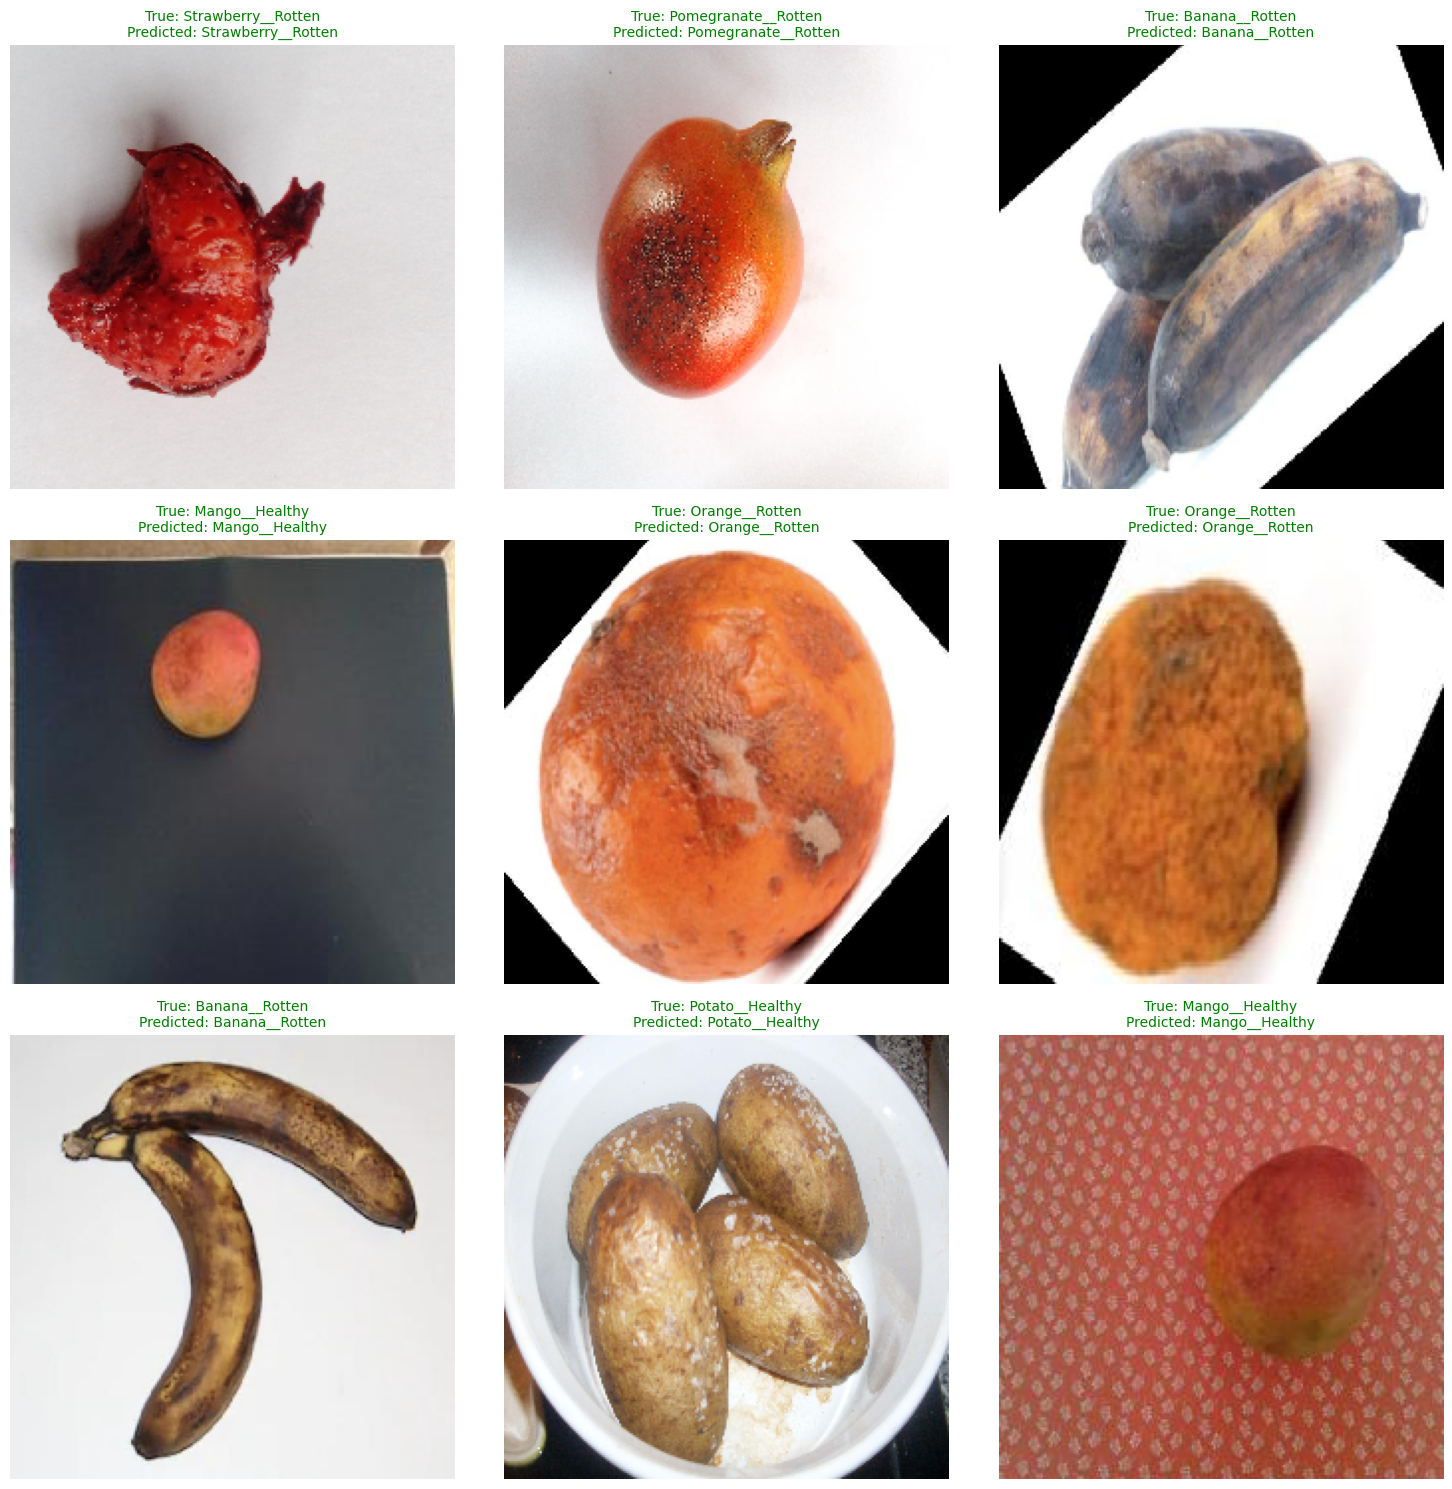

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Generate predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)  # Predicted class indices
actual_labels = test_generator.classes  # True class indices

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Select random samples for visualization
sample_indices = np.random.choice(len(test_generator.filenames), 9, replace=False)

# Plot the results in a 3x3 grid
plt.figure(figsize=(15, 15))

for i, idx in enumerate(sample_indices):
    # Load image
    img_path = test_generator.filepaths[idx]
    img = load_img(img_path, target_size=(224, 224))  # Resize to match model input size

    # Actual and predicted labels
    true_label = class_labels[actual_labels[idx]]
    predicted_label = class_labels[predicted_labels[idx]]

    # Display image
    plt.subplot(3, 3, i + 1)  # 3 rows, 3 columns
    plt.imshow(img)
    plt.axis('off')

    # Set label color (Green = Correct, Red = Incorrect)
    if true_label == predicted_label:
        color = 'green'
    else:
        color = 'red'

    # Title with True and Predicted Labels
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}",
              fontsize=10, color=color)

# Show the plot
plt.tight_layout()
plt.show()

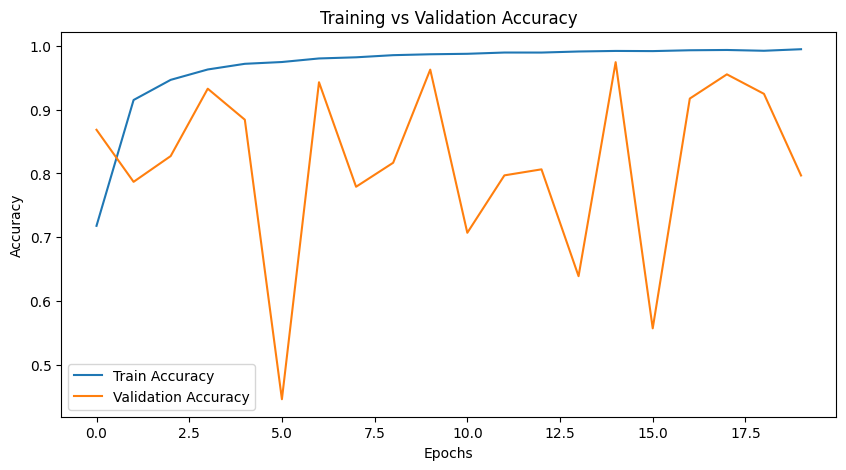

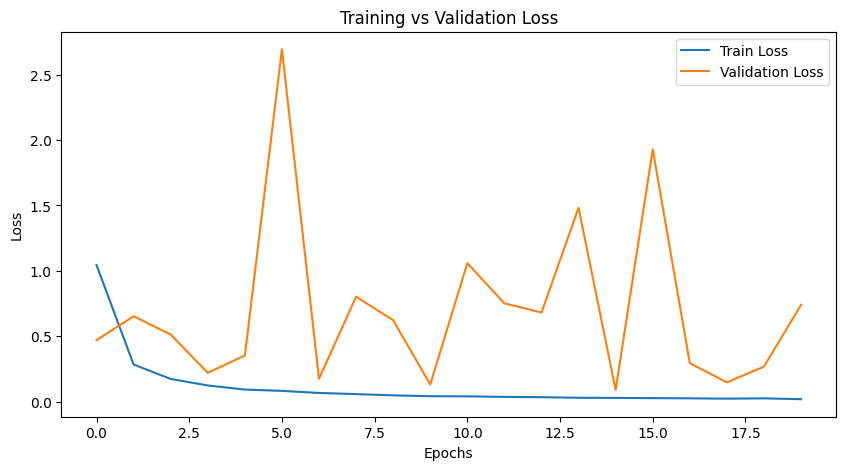

In [37]:

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [ ]:
# Save the model in HDF5 format (.h5 file)
model.save('/kaggle/working/fruit_veg_model.h5')